### Isha Jayswal: 101510506
### Pranali Karande: 101471932
### Mohammad Abuhannood: 101437484
### Luis Alfredo Nogales: 101512133
### Braulio J Cespedes: 101501661
### Alimul Hasan Jami: 101474810

# Emotion Detection
### The dataset contain 35,685 examples of 48x48 pixel gray scale images of faces divided into train and test dataset. Images are categorized based on the emotion shown in the facial expressions (happiness, neutral, sadness, anger, surprise, disgust, fear).

### Kaggle Link: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer

# 1. Install Dependencies and Setup

In [20]:
%pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [44 lines of output]
  Traceback (most recent call last):
    File "D:\DataScience\Anaconda\Lib\site-packages\setuptools\_vendor\packaging\requirements.py", line 35, in __init__
      parsed = _parse_requirement(requirement_string)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "D:\DataScience\Anaconda\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 64, in parse_requirement
      return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "D:\DataScience\Anaconda\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 82, in _parse_requirement
      url, specifier, marker = _parse_requirement_details(tokenizer)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "D:\DataScience\Anaconda\Lib\site-packages\setuptools\_vendo

In [21]:
%pip list

Package                       Version
----------------------------- ---------------
absl-py                       2.1.0
aiobotocore                   2.5.0
aiofiles                      22.1.0
aiohttp                       3.8.5
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
altair                        5.3.0
anaconda-anon-usage           0.4.2
anaconda-catalogs             0.2.0
anaconda-client               1.12.1
anaconda-cloud-auth           0.1.3
anaconda-navigator            2.5.2
anaconda-project              0.11.1
annotated-types               0.7.0
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
async-time

In [22]:
import tensorflow as tf
import os

In [23]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [24]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [25]:
import cv2
import imghdr

In [26]:
data_dir = 'data' 

In [27]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [28]:
for folder in ['train', 'test']:
    folder_path = os.path.join(data_dir, folder)
    for image_class in os.listdir(folder_path):
        class_path = os.path.join(folder_path, image_class)
        if not os.path.isdir(class_path):
            continue
        for image in os.listdir(class_path):
            image_path = os.path.join(class_path, image)
            try:
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)
                if tip not in image_exts:
                    print('Image not in ext list {}'.format(image_path))
                    os.remove(image_path)
            except Exception as e:
                print('Issue with image {}'.format(image_path))

# 3. Load Data

In [29]:
import numpy as np
from matplotlib import pyplot as plt

In [30]:
train_data = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'train'),
    image_size=(256, 256),
    batch_size=32
)

Found 12045 files belonging to 2 classes.


In [31]:
test_data = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'test'),
    image_size=(256, 256),
    batch_size=32
)

Found 3021 files belonging to 2 classes.


In [32]:
# Visualize some samples
data_iterator = train_data.as_numpy_iterator()
batch = data_iterator.next()

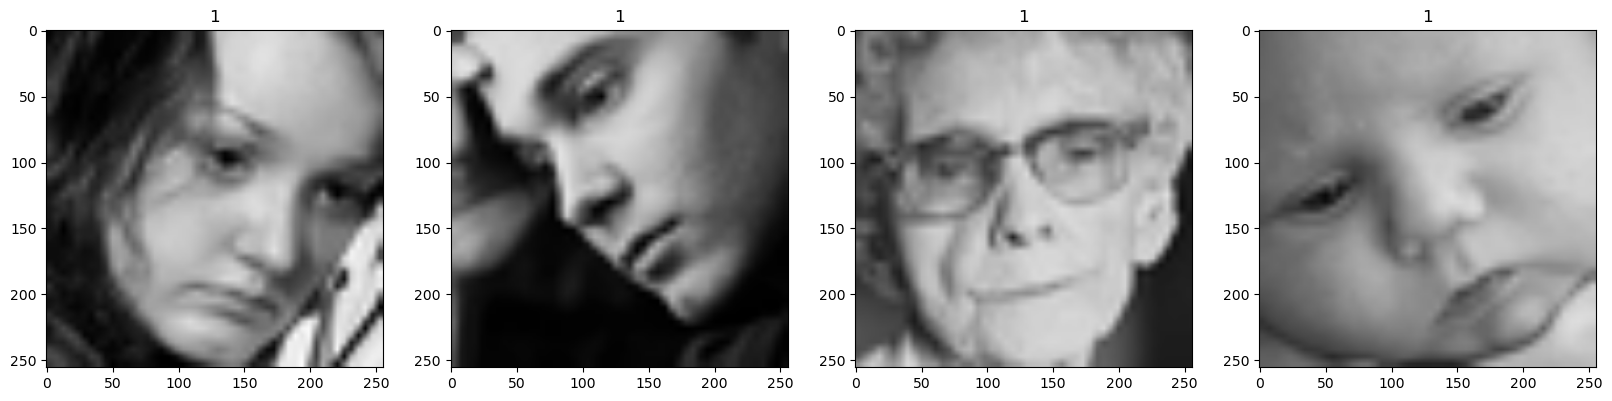

In [33]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
plt.show()

# 4. Data Augmentation


In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 5. Preprocessing and Split Data


In [35]:
train_data = train_data.map(lambda x, y: (x / 255, y))
test_data = test_data.map(lambda x, y: (x / 255, y))

In [36]:
val_size = int(len(train_data) * 0.2)
val_data = train_data.take(val_size)
train_data = train_data.skip(val_size)

# 6. Build CNN Model

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [38]:
cnn_model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [39]:
cnn_model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train CNN Model

In [40]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

cnn_hist = cnn_model.fit(train_data, epochs=5, validation_data=val_data, callbacks=[tensorboard_callback])


Epoch 1/5
302/302 [==============================] - 115s 372ms/step - loss: 0.6338 - accuracy: 0.6389 - val_loss: 0.5770 - val_accuracy: 0.6783
Epoch 2/5
302/302 [==============================] - 115s 378ms/step - loss: 0.5348 - accuracy: 0.7237 - val_loss: 0.5047 - val_accuracy: 0.7504
Epoch 3/5
302/302 [==============================] - 115s 376ms/step - loss: 0.4734 - accuracy: 0.7635 - val_loss: 0.4794 - val_accuracy: 0.7608
Epoch 4/5
302/302 [==============================] - 113s 372ms/step - loss: 0.4162 - accuracy: 0.7962 - val_loss: 0.4624 - val_accuracy: 0.7792
Epoch 5/5
302/302 [==============================] - 123s 405ms/step - loss: 0.3544 - accuracy: 0.8338 - val_loss: 0.4863 - val_accuracy: 0.7750


# 8. Build Dense Model

In [41]:
dense_model = Sequential([
    Flatten(input_shape=(256, 256, 3)),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

dense_model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
dense_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 196608)            0         
                                                                 
 dense_2 (Dense)             (None, 512)               100663808 
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 100,795,393
Trainable params: 100,795,39

# 9. Train Dense Model

In [42]:
dense_hist = dense_model.fit(train_data, epochs=5, validation_data=val_data, callbacks=[tensorboard_callback])

Epoch 1/5
302/302 [==============================] - 184s 603ms/step - loss: 9.6768 - accuracy: 0.5766 - val_loss: 0.6795 - val_accuracy: 0.5883
Epoch 2/5
302/302 [==============================] - 179s 588ms/step - loss: 0.7017 - accuracy: 0.6024 - val_loss: 0.6776 - val_accuracy: 0.5892
Epoch 3/5
302/302 [==============================] - 179s 589ms/step - loss: 0.6731 - accuracy: 0.6023 - val_loss: 0.6786 - val_accuracy: 0.5858
Epoch 4/5
302/302 [==============================] - 178s 587ms/step - loss: 0.6735 - accuracy: 0.6026 - val_loss: 0.6796 - val_accuracy: 0.5833
Epoch 5/5
302/302 [==============================] - 174s 574ms/step - loss: 0.6721 - accuracy: 0.6025 - val_loss: 0.6797 - val_accuracy: 0.5838


# 10. Plot Performance

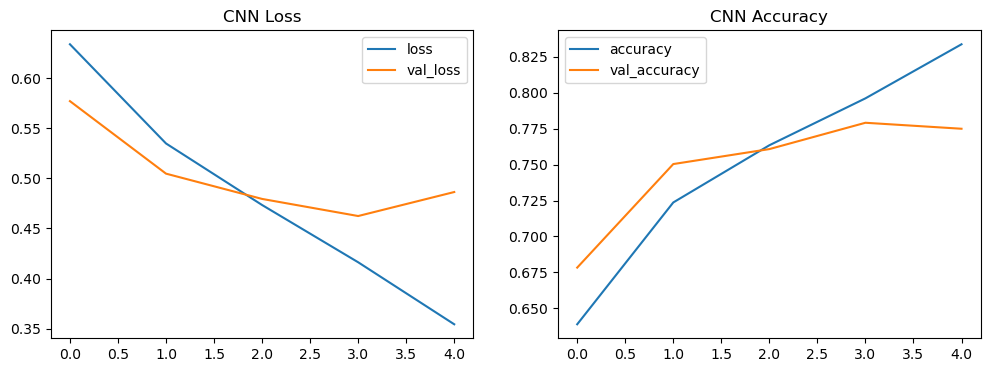

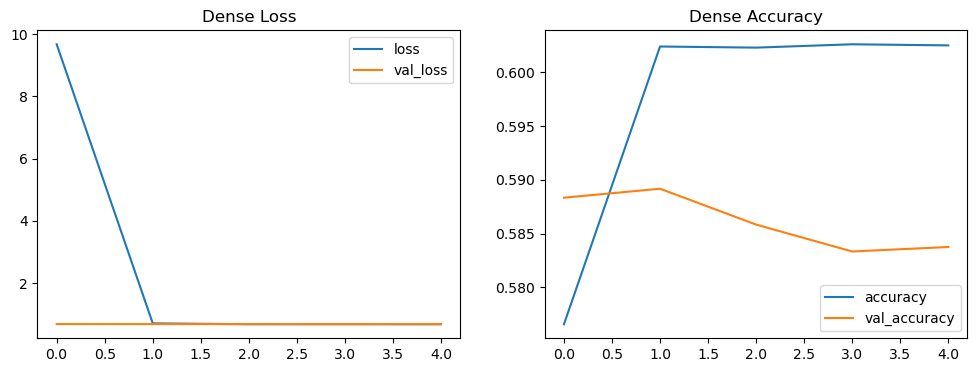

In [43]:
def plot_performance(history, title):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(history.history['loss'], label='loss')
    ax[0].plot(history.history['val_loss'], label='val_loss')
    ax[0].set_title(f'{title} Loss')
    ax[0].legend()

    ax[1].plot(history.history['accuracy'], label='accuracy')
    ax[1].plot(history.history['val_accuracy'], label='val_accuracy')
    ax[1].set_title(f'{title} Accuracy')
    ax[1].legend()

    plt.show()

plot_performance(cnn_hist, 'CNN')
plot_performance(dense_hist, 'Dense')

# 11. Evaluate Models

In [44]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [45]:
def evaluate_model(model, test_data):
    pre = Precision()
    re = Recall()
    acc = BinaryAccuracy()

    for batch in test_data.as_numpy_iterator():
        X, y = batch
        yhat = model.predict(X)
        pre.update_state(y, yhat)
        re.update_state(y, yhat)
        acc.update_state(y, yhat)

    print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

print("CNN Model Evaluation:")
evaluate_model(cnn_model, test_data)

print("Dense Model Evaluation:")
evaluate_model(dense_model, test_data)

CNN Model Evaluation:
1/1 [==============================] - 0s 80ms/step
Precision: 0.7416020631790161, Recall: 0.6904571056365967, Accuracy: 0.7729228734970093
Dense Model Evaluation:
1/1 [==============================] - 0s 69ms/step
Precision: 0.0, Recall: 0.0, Accuracy: 0.586891770362854


# 12. Test and Save the Models

In [46]:
import cv2
from tensorflow.keras.models import load_model

In [47]:
def test_model(model, img_path):
    img = cv2.imread(img_path)
    resize = tf.image.resize(img, (256, 256))
    yhat = model.predict(np.expand_dims(resize / 255, 0))

    if yhat > 0.5:
        print(f'Predicted class is Sad')
    else:
        print(f'Predicted class is Happy')

In [48]:
# Save the models
cnn_model.save(os.path.join('models', 'cnn_imageclassifier.h5'))
dense_model.save(os.path.join('models', 'dense_imageclassifier.h5'))

In [58]:
import matplotlib.image as mpimg

# Load and test the models
new_cnn_model = load_model('models/cnn_imageclassifier.h5')
new_dense_model = load_model('models/dense_imageclassifier.h5')

test_img_path = 'im5.png'  # Replace with the actual test image path
test_model(new_cnn_model, test_img_path)
test_model(new_dense_model, test_img_path)


1/1 [==============================] - 0s 77ms/step
Predicted class is Happy
1/1 [==============================] - 0s 100ms/step
Predicted class is Happy
